# DMC Example: Forces for the Infinite Elliptical Well in 2D

This example shows how to use DMC for a 2D single-particle example, namely, the elliptical box. This is modeled by the Hamiltonian

$$
    H = -\frac{1}{2}\nabla^2
$$

for $x \in \mathcal{E}$, with $\mathcal{E}$ an ellipse centered at the origin with foci at $x_1 = \pm a$. The exact ground state wave function is

$$
    \Psi_0 = \mathrm{Ce}_0(\mu, q_{00})\mathrm{ce}_0(\nu, q_{00}),
$$

with $q_{00} = 0.8253525490491695$, $\mathrm{Ce}_m$ the modified cosine-extended Mathieu function of order $m$, and $\mathrm{ce}_n$ the cosine-extended Mathieu function of order $n$. The parameter $q_{mn}$ is quantized due to the homogeneous Dirichlet boundary condition at $\partial \mathcal{E}$; it determines the energy via

$$
    E_{mn} = 2q_{mn}/a^2.
$$

Thus, the exact ground state energy is $E_{00} = 1.65071$.

We wish to use DMC to estimate the "force"

$$
    F = -\frac{\partial E}{\partial a},
$$

which can be done using the formula

$$
    F = -\left\langle \frac{\partial E_L}{\partial a} + (E_L - E) \frac{\partial}{\partial a}\ln(\pi) \right\rangle,
$$

where $\pi$ indicates the mixed distribution, $\pi(x) = \Phi(x)\Psi_G(x)$, with $\Psi_G$ the guiding wave function. In VMC, the same formula can be used, but instead one uses for $\pi$ the variational distribution $\pi(x) = \Psi_G(x)^2$. In this simple example, one can evaluate the force exactly by using trapezoidal integration, from which we find $F = 7.35205$.

## Set up a DMC Run

We proceed to set up a DMC simulation of the elliptical well:

In [1]:
import sys
sys.path.insert(0, "../")
from pydmc import *
%matplotlib inline

In [11]:
q0 = 0.8253525490491695
a0 = 1
nconf = 100
time_step = 1e-2
reference_energy = 3.67603
#reference_energy =  3.92097
blocks = 100
steps_per_block = 10
# number of equilibration blocks
neq = 10
hamiltonian = lambda psi, x: -0.5*psi.laplacian(x)

As a trial wave function, we use something with the same nodes at the boundary of the ellipse as the analytical ground state. We use $\Psi_G = x\Psi_0(x, y)$,
which has a variational energy of

$$
    E_V = 3.67603.
$$

In [12]:
import scipy.special as spec

def mathieu_modcem1(m, q, x):
    return spec.mathieu_modcem1(m, q, x)

def mathieu_cem(m, q, x):
    # Angular mathieu function in scipy takes input
    # in degrees
    return spec.mathieu_cem(m, q, x*180/np.pi)

def ground_state(mu, nu):
    return mathieu_modcem1(0, q0, mu)[0]*mathieu_cem(0, q0, nu)[0]

class GuidingWaveFunction(WaveFunction, GeometryParametrized):

    def __init__(self, a):
        self._a = a

    def __call__(self, x):
        x, y = x
        #alpha = self._a[0]*np.cosh(1)
        #beta = self._a[0]*np.sinh(1)
        #r = np.sqrt((x/alpha)**2 + (y/beta)**2)
        #return (r + 1)/2 * (1 - (r+1)/2)
        mu = np.real(np.arccosh((x + 1j*y)/self._a[0]))
        nu = np.imag(np.arccosh((x + 1j*y)/self._a[0]))
        return x*ground_state(mu, nu)

    def gradient(self, x):
        return gradient_fd(self, x)
    
    def laplacian(self, x):
        return laplacian_fd(self, x)

    def geometry_parameters(self):
        return self._a

    def deform(self, parameter_change):
        return GuidingWaveFunction(self._a + parameter_change)

In [13]:
brancher = SRBrancher()
#brancher = SimpleBrancher()
ar = DiffuseAcceptReject(fixed_node=True)
guiding_wf = GuidingWaveFunction(np.array([a0]))

In [14]:
np.random.seed(0)

nu_rand = np.random.uniform(0, 2*np.pi)
x0 = np.array([a0*np.cosh(1)*np.cos(nu_rand), a0*np.sinh(1)*np.sin(nu_rand)], dtype=object)
norm = guiding_wf.gradient(x0) / np.linalg.norm(guiding_wf.gradient(x0))
eps = 1e-1
xstart = x0 + eps * norm

#confs = [copy.deepcopy(xstart) for _ in range(nconf)]
confs = [np.random.uniform(low=-1, high=1, size=2) for _ in range(nconf)]
walkers = [Walker(conf, 1.0) for conf in confs]


Since in DMC, we do not have direct access to the distribution $\pi(x)$, we cannot use the same expression used for the forces in VMC. Instead, we use the VD approximation, wherein the forces are calculated as

$$
    F = -\left\langle
        \nabla_a E_L(x_n) + [E_L(x_n) - E]\left(
            \sum_{i=n-k}^{n-1}\nabla_a \ln G(x_{i+1}, x_i) + \nabla_a \ln \pi(x_{n-k}) 
        \right)
    \right\rangle,
$$

where $G$ denotes the drift-diffusion Green function; disregarding normalization,

$$
    G(x_{i+1}, x_i) = \exp\left(
        -\frac{(x_{i+1} - x_i - V(x_i)\tau)^2}{2\tau}
    \right)
    \exp\left(
        S(x_{i+1}, x_i)
    \right)
$$

with

$$
    S(x_{i+1}, x_i) = \tau\left(
        E_{ref} - \frac{1}{2}(E_L(x_{i+1}) + E_L(x_i)),
    \right)
$$

and $k$ is chosen such that $\pi(x_{n-k})$ and $E_L(x_n)$ are uncorrelated. For simplicity, we just take $k$ to be the block size. In the code below, this expression is evaluated using finite differences. To do this, we accumulate samples for both a primary and a secondary geometry, where the ellipse is stretched by displacing the foci by $\Delta a$ in either direction.

In [15]:
da = 1e-3
fa = ForcesDriftDifGfunc(np.array([da]), nconf)
dmc = DMC(hamiltonian, walkers, brancher, ar, guiding_wf, reference_energy, force_accumulator=fa)

accum = dmc.run_dmc(time_step, blocks, steps_per_block, neq=neq, progress=True)

100%|██████████| 100/100 [02:21<00:00,  1.41s/it]


Obtain the results for the DMC energy and its estimated error:

In [16]:
energy = dmc.energy_estimate[-1]
err = dmc.energy_error[-1]
print(f"DMC Energy:   {energy:.5f} +/- {err:.5f}")
print(f"Variational:  {reference_energy:.5f}")
print(f"Exact:        {2*q0/a0**2:.5f}")

DMC Energy:   3.64192 +/- 0.01275
Variational:  3.67603
Exact:        1.65071


See how the energy estimate evolved over time:

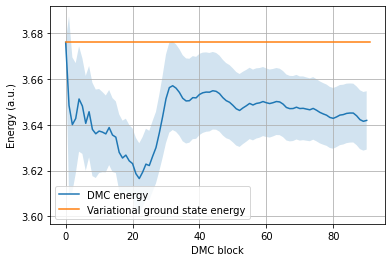

In [17]:
plt.figure()
ns = np.arange(0, len(dmc.energy_estimate))
plt.plot(ns, dmc.energy_estimate, label="DMC energy")
plt.fill_between(ns, dmc.energy_estimate - dmc.energy_error, dmc.energy_estimate + dmc.energy_error, alpha=0.2)

plt.plot([0, len(dmc.energy_estimate)], [reference_energy, reference_energy], label="Variational ground state energy")
#plt.plot([0, len(dmc.energy_estimate)], [exact, exact], label="Exact ground state energy")
plt.legend()
plt.xlabel("DMC block")
plt.ylabel("Energy (a.u.)")
plt.grid()

Finally, we extract the data necessary to compute the force estimate. The work to compute the force is done in a separate function.

In [18]:
fa = dmc.force_accumulator
fl, ws = fa.compute_forces(steps_per_block)
f = np.average(fl, weights=ws, axis=1)
f_err = block_error(fl[0, :], block_size=steps_per_block)
print(f"DMC force: {f[0]:.5f} +/- {f_err:.5f}")

DMC force: 10.48517 +/- 0.08702


Plot the data trace of the "local force" over time:

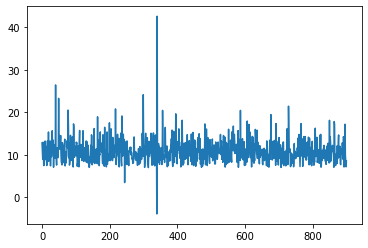

In [19]:
plt.plot(bin_samples(fl[0, :]))